In [64]:
include("../src/HPFEM.jl")

HPFEM

In [107]:
nel = 10
nnodes = nel + 1
idir = [1]#,nnodes]
M = 9
Q = M+2
bas = HPFEM.Basis1d(M,Q)
lmap = HPFEM.locmap(bas)
dof = HPFEM.DofMap1d(lmap, nnodes, idir);


In [108]:
fun(x) = cos(5π*x)

fun (generic function with 1 method)

In [109]:
a = -0.1
b = 2.6
nodes = collect(linspace(a, b, nnodes))

11-element Array{Float64,1}:
 -0.1 
  0.17
  0.44
  0.71
  0.98
  1.25
  1.52
  1.79
  2.06
  2.33
  2.6 

In [110]:
elems = [HPFEM.Element1d(e, nodes[e], nodes[e+1], bas) for e = 1:nel];

In [111]:
solver = HPFEM.CholeskySC(dof, HPFEM.BBSymTri);

In [112]:
for e = 1:nel
    Ae = HPFEM.mass_matrix(bas, elems[e])
    HPFEM.add_local_matrix(solver, e, Ae)
end


In [113]:
Fe = zeros(HPFEM.nmodes(lmap), nel)

for e = 1:nel
    fe = fun(elems[e].x)
    HPFEM.add_rhs!(bas, elems[e], fe, sub(Fe, :, e))
end

# Apply Dirichilet BCs:
Fe[1,1] = fun(a)
#Fe[2,2] = cos(b)
Fe


9x10 Array{Float64,2}:
  6.12323e-17  -0.0544202    -0.027624    …  -0.0494953     0.0785484  
  0.0155274     0.0629379    -0.0726738      -0.0587316    -0.0218252  
  0.0236666     0.00217778   -0.025644       -0.0276713     0.0145029  
 -0.0142859     0.0272572    -0.0104631      -0.00214518   -0.0233124  
 -0.011451     -0.00105371    0.0124077       0.0133886    -0.00701716 
  0.00231307   -0.00441329    0.00169412  …   0.000347333   0.00377458 
  0.000939844   8.64835e-5   -0.00101837     -0.00109888    0.000575937
 -0.000115448   0.000220272  -8.45552e-5     -1.73358e-5   -0.000188394
 -3.16384e-5   -2.91134e-6    3.42819e-5      3.6992e-5    -1.93881e-5 

In [114]:
HPFEM.solve!(solver, Fe)

9x10 Array{Float64,2}:
  6.12323e-17  -0.890988     0.809        …   0.587773     0.453981   
 -0.890988      0.809        0.156431         0.453981    -0.999979   
  4.72994       0.435244    -5.12513         -5.5303       2.89851    
 -1.1897        2.26993     -0.871349        -0.178647    -1.94141    
 -0.593377     -0.0546019    0.642954         0.693783    -0.363622   
  0.0866337    -0.165296     0.0634515    …   0.013009     0.141373   
  0.0275184     0.00253222  -0.0298176       -0.0321749    0.0168633  
 -0.00282396    0.00538806  -0.0020683       -0.00042405  -0.00460828 
 -0.000666354  -6.13172e-5   0.000722029      0.00077911  -0.000408342

In [115]:
nξ = 101
ξ = collect(linspace(-1,1,nξ));
ϕ = zeros(nξ, M)
for i = 1:M
    ϕ[:,i] = bas(ξ, i)
end

Ue = ϕ * Fe;



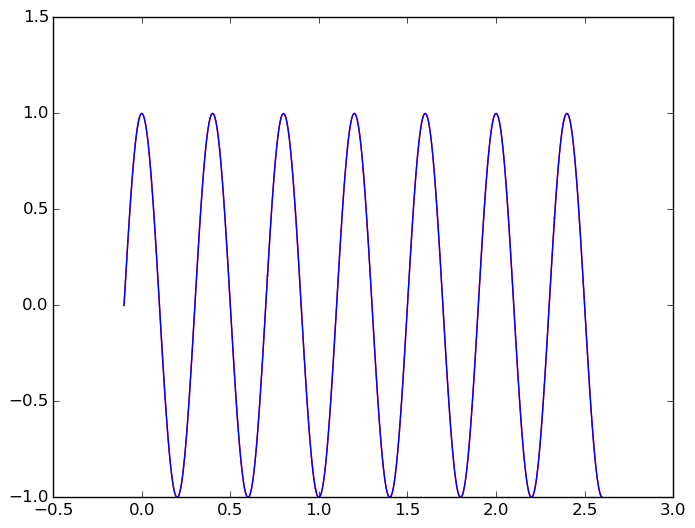

2.127148057018413e-5

In [116]:
using PyPlot
x = [(1-ξ)*el.a/2 + (1+ξ)*el.b/2 for el in elems]
maxerr = 0.0
for e = 1:nel
    uu = fun(x[e])
    err = maxabs(uu-Ue[:,e])
    if err > maxerr maxerr = err end
        
    plot(x[e], Ue[:,e], "r", x[e], uu, "b")
end
maxerr